Here are some notes and calculations that arose from thinking about how _good_ various shuffling techniques are for MTG. 

In [62]:
from copy import deepcopy
from matplotlib import pyplot as plt
import random

In [14]:
# first let's set up a deck
n_cards = 100
lands = {
    'white': 0,
    'black': 0,
    'red': 20,
    'green': 20,
    'blue': 0,
}

ordered_deck = []
for land, number in lands.items():
    ordered_deck.extend([land]*number)
ordered_deck.extend([*range(1, n_cards - len(ordered_deck))])
print(f'ordered_deck created with {len(ordered_deck)} cards (comander is separate)')

ordered_deck created with 99 cards (comander is separate)


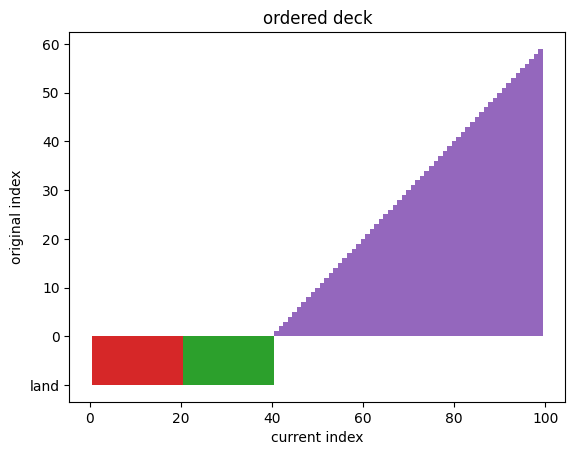

In [60]:
# let's create a function to visualise deck order
def visualise(library: list, title: str = None) -> None:
    """visualises library order"""
    fig, ax = plt.subplots()

    # create a bar axis with the card indecies of unique cards and a fixed
    # index for land original position doesn't matter for it.
    # land_height = max([val for val in library if isinstance(val, int)]) + 1
    land_height = -10
    bar_colours = []
    bar_heights = []
    for card in library:
        if isinstance(card, int):
            bar_colours.append('tab:purple')
            bar_heights.append(card)
        else:
            bar_colours.append(f'tab:{card}')
            bar_heights.append(land_height)
    bar_indecies = list(range(1, len(library) + 1))
    ax.bar(bar_indecies, bar_heights, color=bar_colours, width=1)

    # set up the axis labels and plot title
    ax.set_ylabel('original index')
    y_vals, y_labels = ax.get_yticks(), ax.get_yticklabels()
    for y, label in zip(y_vals, y_labels):
        if y == land_height:
            label.set_text('land')
            break
    ax.set_yticks(y_vals[1:-1])
    ax.set_yticklabels(y_labels[1:-1])
    ax.set_xlabel('current index')
    if title is not None:
        ax.set_title(title)


visualise(ordered_deck, title='ordered deck')

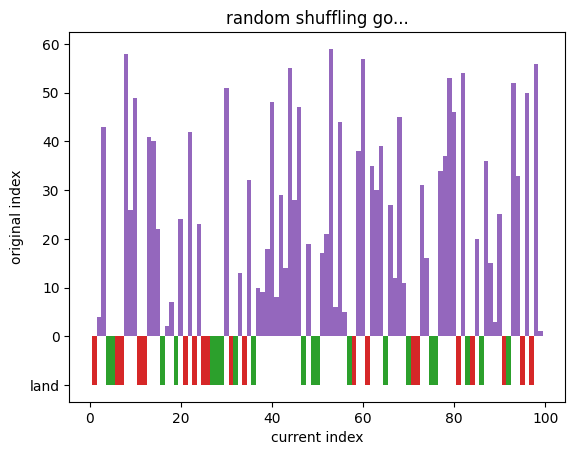

In [67]:
# ok let's try it out
random_order = deepcopy(ordered_deck)
random.shuffle(random_order)
visualise(random_order, 'random shuffling go...')

In [ ]:
# let's try extract a metrics of how well shuffled a library is
def land_distribution(library: list) -> None:
    """computes a metric of how well distributed land is"""
    